In [1]:
import os
import sys
sys.path.append('../../Utils')
from metrics import compute_metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, '../../../Data/')

data_path = data_dir+'/29Atlas/protein_embeddings/nn_dataset.tsv'

In [2]:
device = 1
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[device], 'GPU')

print(f'TF eager exectution: {tf.executing_eagerly()}')
print(f'Using device {physical_devices[device]}')

TF eager exectution: True
Using device PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [3]:
class General_MLP(keras.Model):
    def __init__(self,hidden_nodes,input_shape=None):
        '''
        hidden nodes - all the dimensions after input including output size
        input shape is optional, if not specified then network takes input shape as the shape of the first vector passed to it.
        '''
        super(General_MLP, self).__init__()
        self.mlp_layers = []
        for nodes in hidden_nodes[0:-1]: 
            self.mlp_layers.append(keras.layers.Dense(nodes, activation='relu'))
            
        self.mlp_layers.append(keras.layers.Dense(hidden_nodes[-1]))
        
        if type(input_shape) != type(None):
            self.build(input_shape)
    
    #training flag if specific layers behave differently, for mlp no difference
    def call(self, inputs, training=False):
        for layer in self.mlp_layers:
            inputs = layer(inputs)
        return inputs

In [4]:
atlas_mlp = General_MLP([64,32,3,1],input_shape=(1,66))
atlas_mlp.summary()

Model: "general_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  4288      
_________________________________________________________________
dense_1 (Dense)              multiple                  2080      
_________________________________________________________________
dense_2 (Dense)              multiple                  99        
_________________________________________________________________
dense_3 (Dense)              multiple                  4         
Total params: 6,471
Trainable params: 6,471
Non-trainable params: 0
_________________________________________________________________


In [5]:
#optimizer = tf.keras.optimizers.RMSprop(0.001)
#optimizer = tf.keras.optimizers.SGD(0.001) #-> need lr, momentum, neustrov?
optimizer = tf.keras.optimizers.Adam()
mse_loss_fn = tf.keras.losses.MeanSquaredError()
mse_loss_fn_v = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()
vloss_metric = tf.keras.metrics.Mean()

### Import data and create train, validation and test set.

In [6]:
atlas_data = pd.read_csv(data_path,sep='\t',index_col=0).astype(np.float32)

In [7]:
print(atlas_data.shape)
atlas_data.head()

(232919, 67)


,protein,mrna,protein_length,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
A2M_Adrenal,9.444,3.154,10.525521,0.038579,0.173506,-0.130435,-0.936089,-0.041486,-0.335922,0.103442,...,0.125525,0.013637,0.017146,-0.015429,-0.014028,0.278659,-0.174157,-0.061808,0.547407,-0.007637
A4GALT_Adrenal,5.467,1.625,8.463525,-0.021238,0.090200,-0.107737,-0.954438,-0.046315,-0.310370,0.075852,...,0.155519,0.027173,0.072275,-0.004112,-0.052762,0.239089,-0.078361,-0.065273,0.394913,-0.005416
AAAS_Adrenal,6.827,2.314,9.092757,0.036048,0.110593,-0.096235,-0.972981,-0.038344,-0.285189,0.042900,...,0.156817,0.015685,0.135258,-0.032438,-0.042827,0.208018,-0.072004,-0.047945,0.314613,-0.021386
AACS_Adrenal,6.296,1.737,9.392318,-0.078363,0.115565,-0.106326,-0.962264,-0.026361,-0.175895,0.091822,...,0.120208,0.010343,-0.044220,-0.025518,-0.029130,0.313736,-0.115714,-0.036679,0.423880,-0.013957
AADAC_Adrenal,8.090,2.980,8.640244,-0.035582,0.130290,-0.086787,-0.941683,-0.025509,-0.380224,0.098700,...,0.108652,0.015800,-0.056896,0.002625,-0.047716,0.388146,-0.174945,-0.042153,0.653626,-0.012216


In [8]:
ZSCORE = True
SEED = 10
train,test = train_test_split(atlas_data,test_size=0.2,random_state=SEED)
SEED = 42
test,val = train_test_split(test,test_size=0.5,random_state=SEED)
SEED = 82
test,overfit = train_test_split(test,test_size=0.05,random_state=SEED)

def zscore(train_df):
    assert isinstance(train_df,pd.DataFrame)
    means = train_df.mean(axis=0)
    stds = train_df.std(axis=0)
    zscored = (train_df-means)/stds
    return zscored, means, stds

if ZSCORE:
    print(f'Data is z-scored')
    train, train_mean, train_std = zscore(train) #zscore data
    val = (val-train_mean)/train_std #zscore validation data using mean and std from train set
    test = (test-train_mean)/train_std #zscore test data using mean and std from train set
    overfit = (overfit-train_mean)/train_std

Data is z-scored


In [9]:
BATCH = 64
x_train = train.drop(columns='protein').values
y_train = train[['protein']].values

x_val = val.drop(columns='protein').values
y_val = val[['protein']].values

x_test = test.drop(columns='protein').values
y_test = test[['protein']].values

x_overfit = overfit.drop(columns='protein').values
y_overfit = overfit[['protein']].values

print(f'train dataset size: {x_train.shape}')
print(f'validation dataset size: {x_val.shape}')
print(f'test dataset size: {x_test.shape}')
print(f'overfit dataset size: {x_overfit.shape}')

trn_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
trn_dataset = trn_dataset.shuffle(buffer_size=x_train.shape[0]).batch(BATCH) #I think default is 32

overfit_dataset = tf.data.Dataset.from_tensor_slices((x_overfit,y_overfit))
overfit_dataset = overfit_dataset.shuffle(buffer_size=x_overfit.shape[0]).batch(BATCH)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_dataset = val_dataset.batch(BATCH)

train dataset size: (186335, 66)
validation dataset size: (23292, 66)
test dataset size: (22127, 66)
overfit dataset size: (1165, 66)


In [10]:
# def norm_dataset(raw_data,train_mean,train_std):
#     norm_data = (raw_data-train_mean)/train_std
#     return norm_data

# train, test = train_test_split(atlas_data, test_size=0.2,random_state = 0,shuffle=True)
# train, validation = train_test_split(train, test_size=0.2,random_state = 0,shuffle=True)
# _, overfit_batch = train_test_split(train, test_size=0.005,random_state = 0,shuffle=True)

# train_y = train.pop('protein').values
# train_x = train.values

# train_mean = train_x.mean(axis=0)
# train_std = train_x.std(axis=0)

# train_x = norm_dataset(train_x,train_mean,train_std)

# val_y = validation.pop('protein').values
# val_x = norm_dataset(validation.values,train_mean,train_std)

# test_y = test.pop('protein').values
# test_x = norm_dataset(test.values,train_mean,train_std)

# print(f'train dataset size: {train_x.shape}')
# print(f'validation dataset size: {val_x.shape}')
# print(f'test dataset size: {test_x.shape}')

## Should check if I can overfit a small batch of the data first

In [11]:
# y_overfit = overfit_batch.pop('protein').values
# x_overfit = norm_dataset(overfit_batch.values,train_mean,train_std)

# print(f'train dataset size: {x_overfit.shape}')

By contrast, the buffer_size argument to tf.data.Dataset.shuffle() affects the randomness of the transformation. We designed the Dataset.shuffle() transformation (like the tf.train.shuffle_batch() function that it replaces) to handle datasets that are too large to fit in memory. 

In [12]:
#split data into its train dataset and validation
BATCH = 64
trn_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
trn_dataset = trn_dataset.shuffle(buffer_size=x_train.shape[0]).batch(BATCH) #I think default is 32

overfit_dataset = tf.data.Dataset.from_tensor_slices((x_overfit,y_overfit))
overfit_dataset = overfit_dataset.shuffle(buffer_size=x_overfit.shape[0]).batch(BATCH)

v_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
v_dataset = v_dataset.batch(BATCH)

In [13]:
val_loss = []
train_loss = []

In [26]:
EPOCHS = 25
OVERFIT = False

for epoch in tqdm.tqdm(range(EPOCHS)):
    if OVERFIT:
        dataset = overfit_dataset
    else:
        dataset = trn_dataset

    for step, (x_batch,y_batch) in enumerate(dataset): #iterate over batches of the dataset
        with tf.GradientTape() as tape:
            #forward pass
            prediction = atlas_mlp(x_batch,training=True)
            #compute loss over regressor values
            loss = mse_loss_fn(y_batch,tf.squeeze(prediction))

        grads = tape.gradient(loss, atlas_mlp.trainable_weights)
        optimizer.apply_gradients(zip(grads, atlas_mlp.trainable_weights))
        #average loss over batches
        loss_metric(loss)
        
    #Validation loss
    for (x_batch_val,y_batch_val) in v_dataset:
        v_prediction = atlas_mlp(x_batch_val)
        v_loss = mse_loss_fn_v(y_batch_val,tf.squeeze(v_prediction))
        vloss_metric(v_loss)
        
    #if epoch>=1 and epoch % 5 == 0 or epoch == 1:
    #    tqdm.tqdm.write(f'Epoch {epoch}, avg batch loss {loss_metric.result()} improvement {train_loss[-1]-loss_metric.result()}, avg Vbatch loss {vloss_metric.result()}')
    
    train_loss.append(loss_metric.result())
    val_loss.append(vloss_metric.result())
    
    loss_metric.reset_states()
    vloss_metric.reset_states()

  4%|▍         | 1/25 [00:31<12:44, 31.84s/it]

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
fig.set_size_inches(10.5,20.5)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(train_loss)
ax1.plot(val_loss)

ax2.plot(train_loss[-50::])
ax2.plot(val_loss[-50::])

fig.savefig(f"figures/training_{len(train_loss)}_epochs.pdf")

#### If loading saved weights

In [ ]:
# atlas_mlp = General_MLP([64,16,1],input_shape=(1,66))
# atlas_mlp.summary()
# title = f'training_170_epochs_64_16_1'
# atlas_mlp.load_weights(f'results/{title}_modelweights')

### Evalutation on the test set

In [ ]:
predicted = atlas_mlp(x_test).numpy()
results = compute_metrics(predicted,y_test,y_train)
results

In [20]:
predicted = atlas_mlp(x_test).numpy()
results = compute_metrics(predicted,y_test,y_train)
results

{'mae': 0.42159316,
 'mse': 0.31305754,
 'smse': 0.3141038608291405,
 'r2': 0.6858941951969182,
 'evs': 0.6859222650527954,
 'spearmanrho': 0.8205253817296062,
 'spearmanrho_p': 0.0,
 'pearsonr': 0.8283778731973301,
 'pearsonr_p': 0.0,
 'median_abs_fc': 2.123920734635498,
 'mean_abs_fc': 2.6399345474764124}

### Saving model

In [21]:
title = f'training_{len(train_loss)}_epochs_64_32_3_1'
pd.DataFrame.from_dict(results,orient='index').T.to_csv(f'results/{title}_metrics.tsv',sep='\t')
atlas_mlp.save_weights(f'results/{title}_modelweights')

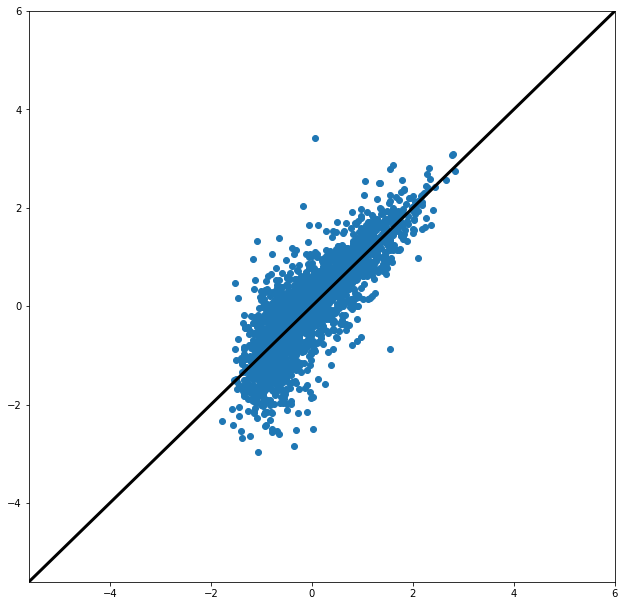

In [22]:
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(predicted[0:2000,:].squeeze(),y_test[0:2000].squeeze())
y_max = int(y_test.max())+2
y_min = y_test.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
# ax.plot([0,1],[0,1], transform=ax.transAxes)
ax.plot(x, x,color='k',linewidth=3)

#pearson = scipy.stats.pearsonr(test_y.squeeze(),mean.numpy().squeeze())[0]
# ax.text(.75,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)
# if SAVE:
#     fig.savefig(f"./results/am04f0/test_predicted_{TITLE}.pdf")

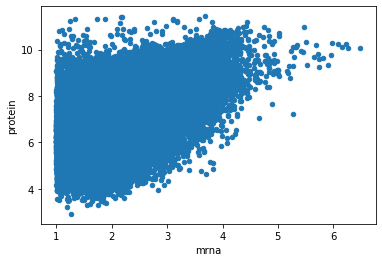

In [23]:
atlas_data.plot.scatter('mrna','protein')

### Trying on a single gene with multiple mRNA
* Need to normalize inputs correctly

In [24]:
train.head()

,protein,mrna,protein_length,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
RMDN3_Fallopiantube,0.826843,0.307286,-0.040441,0.178503,1.056042,-0.076253,-0.052878,-0.283698,0.020665,0.460409,...,0.638705,0.095589,1.160179,-0.131716,1.045125,0.510087,-0.200056,1.135350,-0.884683,0.122335
SLFN5_Urinarybladder,0.640920,-0.049692,0.822324,-0.164264,-0.443737,-0.416854,-0.146531,0.281541,0.370824,0.251156,...,-0.448556,-0.432668,-0.920159,0.696855,-0.478106,-0.886702,0.823005,-0.547656,-0.059201,-0.184311
DOCK8_Testis,0.036907,-0.438052,1.978149,0.056101,-0.534816,-0.450512,-0.283785,-0.304481,0.225786,0.240262,...,-1.103841,-0.335068,-0.449820,-0.098533,0.306080,-1.218829,0.686348,-0.355952,-0.464161,0.115320
TMEM115_Tonsil,-0.306626,-0.700881,-0.434246,1.560372,2.451450,4.229491,-0.342236,0.256980,-0.893482,0.839052,...,0.866318,-0.327382,1.503895,0.387503,-1.765649,1.051569,0.697685,-0.259750,1.698776,-0.653981
UBE2J1_Prostate,0.172810,1.091851,-0.567427,-0.014471,-0.769285,0.075118,-0.425138,0.382776,-0.332805,-0.304529,...,0.022510,-0.106058,-0.075904,0.209388,-0.189486,0.174874,0.113087,-0.210211,0.128855,-0.283051


C19ORF43


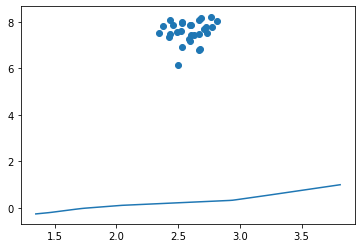

In [25]:
gene = 900
gene_name = atlas_data.index[gene].split('_')[0]
print(gene_name)

bool_list = [gene_name == name.split('_')[0] for name in atlas_data.index]
gene_data = atlas_data.loc[bool_list,:].values #contains both mrna and protein levels

mrna_ranges = np.linspace(gene_data[:,1].min()-1,gene_data[:,1].max()+1,100)
size = mrna_ranges.shape[0]

gene1 = np.tile(gene_data[[0],1::],size).reshape((size,66))
gene1[:,0] = mrna_ranges
gene1_protein = atlas_mlp(gene1).numpy()
plt.plot(mrna_ranges,gene1_protein)
plt.scatter(gene_data[:,1],gene_data[:,0])

### Proving you can overfit a small batch of the data

In [40]:
predicted = atlas_mlp(x_overfit).numpy()

In [41]:
compute_metrics(predicted,y_overfit[:,None],train_y[:,None])

{'mae': 0.238321,
 'mse': 0.10171328,
 'smse': 0.08115869548337108,
 'r2': 0.9187946798871355,
 'evs': 0.9190900325775146,
 'spearmanrho': 0.9572934088267109,
 'spearmanrho_p': 0.0,
 'pearsonr': 0.9600486784901503,
 'pearsonr_p': 0.0,
 'median_abs_fc': 1.5228545804359928,
 'mean_abs_fc': 1.7310954157913858}